In [17]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, date_format, avg, to_date, count, sum, lit
from pyspark.sql.types import TimestampType

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

spark = SparkSession.builder.appName("TestSpark").getOrCreate()

In [5]:
df_v_gpstrips = spark.read.option("header", True).csv("data/v_gpstrips.csv")

# Show the first few rows
df_v_gpstrips.show(10)

print(f"Total number of trips recorded: {df_v_gpstrips.count()}")

+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------------+--------+
| sampno|vehno|gpstripid|gpstravdayid|gpstravdaytripid|         start_time|           end_time|duration_min|distance_miles|avg_speed_mph|max_speed_mph|origin_lon|origin_lat|destination_lon|destination_lat|destination_distfromlast|gaptime|tripareatype|workrelated|nontransport|onsite|looptrip|origin_loc_type|destination_loc_type|    geom|
+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------

In [22]:

columns_to_convert = ['duration_min', 'distance_miles']  # List of columns to convert

for col_name in columns_to_convert:
    df_v_gpstrips = df_v_gpstrips.withColumn(col_name, col(col_name).cast("float"))

time_columns = ["start_time", "end_time"]

for col_name in time_columns:
    df_v_gpstrips = df_v_gpstrips.withColumn(col_name, col(col_name).cast(TimestampType()))



In [23]:
df_v_gpstrips = df_v_gpstrips.withColumn("start_time_hour", date_format("start_time", "HH:mm:ss"))

df_v_gpstrips.show(10)

+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------------+--------+---------------+
| sampno|vehno|gpstripid|gpstravdayid|gpstravdaytripid|         start_time|           end_time|duration_min|distance_miles|avg_speed_mph|max_speed_mph|origin_lon|origin_lat|destination_lon|destination_lat|destination_distfromlast|gaptime|tripareatype|workrelated|nontransport|onsite|looptrip|origin_loc_type|destination_loc_type|    geom|start_time_hour|
+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+-------

In [17]:
df_v_gpstrips.filter(col('sampno') == '2527998').show(10)

+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------------+--------+---------------+
| sampno|vehno|gpstripid|gpstravdayid|gpstravdaytripid|         start_time|           end_time|duration_min|distance_miles|avg_speed_mph|max_speed_mph|origin_lon|origin_lat|destination_lon|destination_lat|destination_distfromlast|gaptime|tripareatype|workrelated|nontransport|onsite|looptrip|origin_loc_type|destination_loc_type|    geom|start_time_hour|
+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+-------

In [32]:

df_count = (
    df_v_gpstrips.withColumn("date", to_date(col("start_time")))
    .groupBy("sampno", "vehno", "date")
    .agg(
        count("*").alias("nb_trips_day"),
        avg("duration_min").alias("avg_duration_min"),
        avg("distance_miles").alias("avg_trip_distance_miles"),
        sum("distance_miles").alias("total_distance_miles"),
    )
)

df_count.show(10)

df_count_summary = df_count.agg(avg('total_distance_miles').alias('avg_daily_distance_miles'))

df_count_summary.show()

+-------+-----+----------+------------+------------------+-----------------------+--------------------+
| sampno|vehno|      date|nb_trips_day|  avg_duration_min|avg_trip_distance_miles|total_distance_miles|
+-------+-----+----------+------------+------------------+-----------------------+--------------------+
|2527998|    2|2013-01-09|          10| 3.019999635219574|     0.8251395046710968|   8.251395046710968|
|2233056|    1|2012-08-02|           2|17.110000610351562|       11.6114501953125|     23.222900390625|
|1150191|    1|2012-04-20|           6|28.096666832764942|      28.31895001232624|  169.91370007395744|
|2538023|    1|2012-11-16|          18|4.5077775319417315|     1.9472273571623697|   35.05009242892265|
|2741339|    1|2012-12-12|           5|  14.9979998588562|      8.261659729480744|   41.30829864740372|
|2654878|    3|2012-12-01|          14|3.5499999480588094|     1.3255281570766653|  18.557394199073315|
|1987680|    2|2012-07-26|           3|17.946666876475017|      

In [29]:
# Convert PySpark DataFrame to Pandas
pandas_df = df_v_gpstrips.select("start_time_hour").toPandas()

# Sort time strings properly before plotting
pandas_df["start_time_hour"] = pd.to_datetime(pandas_df["start_time_hour"], format="%H:%M:%S")


In [30]:
pandas_df

,start_time_hour
0,1900-01-01 07:51:23
1,1900-01-01 20:58:43
2,1900-01-01 08:49:38
3,1900-01-01 16:56:04
4,1900-01-01 17:44:06
...,...
19070,1900-01-01 11:42:09
19071,1900-01-01 09:28:54
19072,1900-01-01 14:17:43
19073,1900-01-01 16:42:33


In [15]:
print(pandas_df.dtypes)

start_time_hour    datetime64[ns]
dtype: object


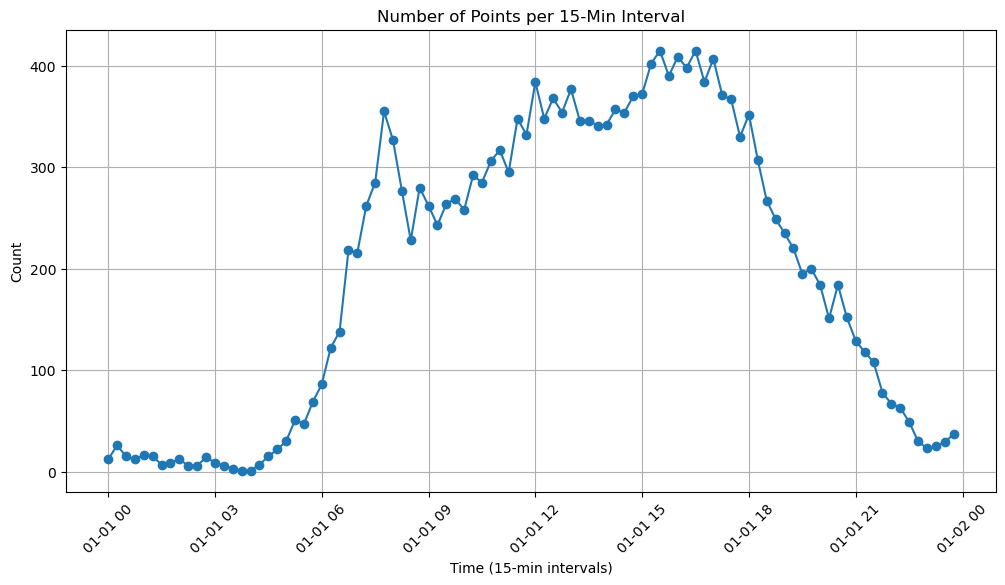

In [31]:
# Round to the nearest 15 minutes
pandas_df["time_15min"] = pandas_df["start_time_hour"].dt.floor("15min")

# Group by the rounded time and count occurrences
grouped_df = pandas_df.groupby("time_15min").size().reset_index(name="count")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(grouped_df["time_15min"], grouped_df["count"], marker="o", linestyle="-")
plt.xlabel("Time (15-min intervals)")
plt.ylabel("Count")
plt.title("Number of Points per 15-Min Interval")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [28]:
for col_name, col_type in df_v_gpstrips.dtypes:
    print(f"Column: {col_name}, Type: {col_type}")


Column: sampno, Type: string
Column: vehno, Type: string
Column: gpstripid, Type: string
Column: gpstravdayid, Type: string
Column: gpstravdaytripid, Type: string
Column: start_time, Type: timestamp
Column: end_time, Type: timestamp
Column: duration_min, Type: float
Column: distance_miles, Type: float
Column: avg_speed_mph, Type: string
Column: max_speed_mph, Type: string
Column: origin_lon, Type: string
Column: origin_lat, Type: string
Column: destination_lon, Type: string
Column: destination_lat, Type: string
Column: destination_distfromlast, Type: string
Column: gaptime, Type: string
Column: tripareatype, Type: string
Column: workrelated, Type: string
Column: nontransport, Type: string
Column: onsite, Type: string
Column: looptrip, Type: string
Column: origin_loc_type, Type: string
Column: destination_loc_type, Type: string
Column: geom, Type: string
Column: start_time_hour, Type: string


In [20]:
from pyspark.sql.functions import mean

mean_value = df_v_gpstrips.select(mean('distance_miles')).collect()[0][0]
print(mean_value)

6.2489625371243624


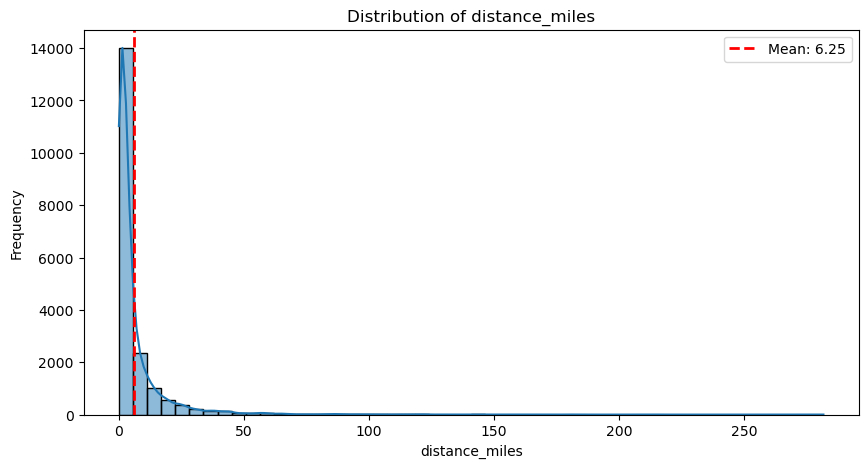

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert column to Pandas DataFrame
pandas_df = df_v_gpstrips.select('distance_miles').toPandas()

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(pandas_df['distance_miles'], bins=50, kde=True)
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.xlabel('distance_miles')
plt.ylabel("Frequency")
plt.title(f"Distribution of {'distance_miles'}")
plt.legend()
plt.show()


In [6]:
df_w_gpstrips = spark.read.option("header", True).csv("data/w_gpstrips.csv")

# Show the first few rows
df_w_gpstrips.show()

df_w_gpstrips.count()

25/02/14 17:47:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+-----------+--------+------------+------------+------------+----------+----------+---------------+---------------+----------------+-------+------------+-----------+------------+------+--------+---------------+--------------------+--------+
| sampno|perno|gpstripid|gpstravdayid|gpstravdaytripid|         start_time|           end_time|duration_min|distance_miles|avg_speed_mph|max_speed_mph|travel_mode|nbstages|travmodelist|numuniqmodes|uniqmodelist|origin_lon|origin_lat|destination_lon|destination_lat|distfromlastdest|gaptime|tripareatype|workrelated|no_transport|onsite|looptrip|origin_loc_type|destination_loc_type|    geom|
+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+-----------+--------+------------+------------+------------+-------

121599

In [11]:
def process_dataframe(df):
    """
    Processes a given DataFrame by converting specified columns to float, casting time columns,
    adding an extracted hour column, and computing aggregated statistics.

    Args:
        df (DataFrame): Input PySpark DataFrame.

    Returns:
        tuple: (df_count, df_count_summary)
    """
    columns_to_convert = ["duration_min", "distance_miles"]
    time_columns = ["start_time", "end_time"]

    for col_name in columns_to_convert:
        df = df.withColumn(col_name, col(col_name).cast("float"))

    for col_name in time_columns:
        df = df.withColumn(col_name, col(col_name).cast(TimestampType()))

    df = df.withColumn("start_time_hour", date_format("start_time", "HH:mm:ss"))

    df_count = (
        df.withColumn("date", to_date(col("start_time")))
        .groupBy("sampno", "perno", "date")
        .agg(
            count("*").alias("nb_trips_day"),
            avg("duration_min").alias("avg_duration_min"),
            avg("distance_miles").alias("avg_trip_distance_miles"),
            sum("distance_miles").alias("total_distance_miles"),
        )
    )

    df_count_summary = df_count.agg(
        avg("total_distance_miles").alias("avg_daily_distance_miles")
    )

    return df_count, df_count_summary

In [12]:
df_count_w, df_count_summary_w = process_dataframe(df_w_gpstrips)
df_count_w.show(10)
df_count_summary_w.show(10)

+-------+-----+----------+------------+------------------+-----------------------+--------------------+
| sampno|perno|      date|nb_trips_day|  avg_duration_min|avg_trip_distance_miles|total_distance_miles|
+-------+-----+----------+------------+------------------+-----------------------+--------------------+
|1043613|    2|2012-05-18|           5| 3.715999889373779|     1.3546794146299361|   6.773397073149681|
|1123731|    1|2012-07-27|          12| 9.749999552965164|     0.8070576754398644|   9.684692105278373|
|1131380|    2|2012-02-09|           3|12.483333110809326|     5.0905000766118365|   15.27150022983551|
|1133036|    1|2012-02-23|           6|11.356666127840677|      6.141949380437533|    36.8516962826252|
|1151272|    3|2012-02-22|           9|  28.7988883389367|     27.928288400173187|  251.35459560155869|
|1227677|    1|2012-03-06|           2| 23.11500072479248|      7.322999477386475|   14.64599895477295|
|1271462|    2|2012-02-23|           6|14.268333276112875|      

+------------------------+
|avg_daily_distance_miles|
+------------------------+
|       38.02080799780584|
+------------------------+



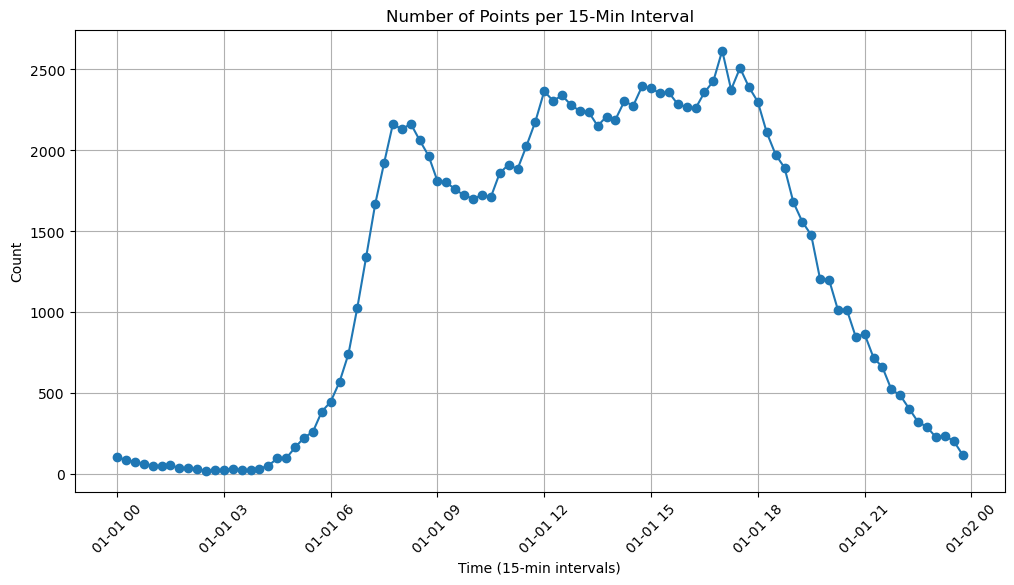

In [14]:
df_w_gpstrips = df_w_gpstrips.withColumn("start_time_hour", date_format("start_time", "HH:mm:ss"))

# Convert PySpark DataFrame to Pandas
pandas_df = df_w_gpstrips.select("start_time_hour").toPandas()

# Sort time strings properly before plotting
pandas_df["start_time_hour"] = pd.to_datetime(pandas_df["start_time_hour"], format="%H:%M:%S")

# Round to the nearest 15 minutes
pandas_df["time_15min"] = pandas_df["start_time_hour"].dt.floor("15min")

# Group by the rounded time and count occurrences
grouped_df = pandas_df.groupby("time_15min").size().reset_index(name="count")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(grouped_df["time_15min"], grouped_df["count"], marker="o", linestyle="-")
plt.xlabel("Time (15-min intervals)")
plt.ylabel("Count")
plt.title("Number of Points per 15-Min Interval")
plt.xticks(rotation=45)
plt.grid()
plt.show()

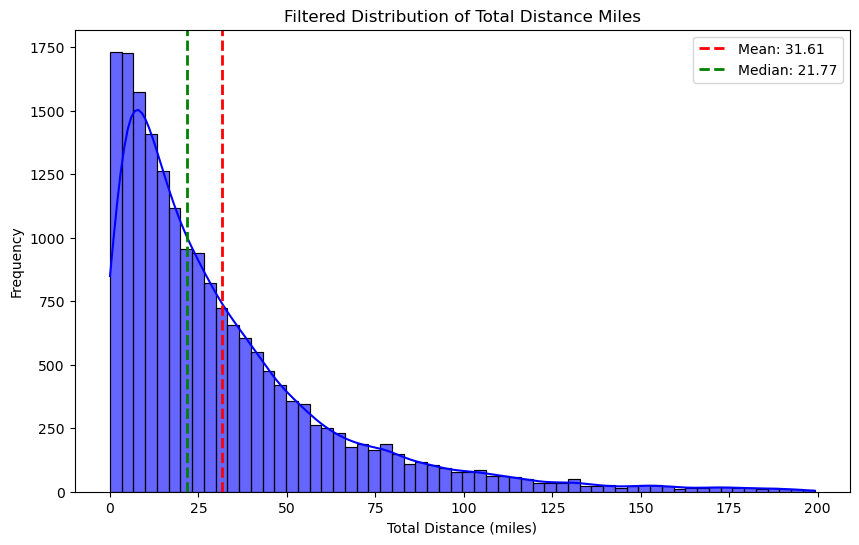

In [25]:
# Convert to Pandas
df_pandas = df_count_w.select("total_distance_miles").toPandas()

# Compute IQR
Q1 = np.percentile(df_pandas["total_distance_miles"], 25)
Q3 = np.percentile(df_pandas["total_distance_miles"], 75)
IQR = Q3 - Q1

# Define limits
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 4.5 * IQR

# Filter data
df_filtered = df_pandas[
    (df_pandas["total_distance_miles"] >= lower_bound)
    & (df_pandas["total_distance_miles"] <= upper_bound)
]

# Compute statistics
mean_value = df_filtered["total_distance_miles"].mean()
median_value = df_filtered["total_distance_miles"].median()

# Plot distribution with mean and median
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered["total_distance_miles"], bins=60, kde=True, color="blue", alpha=0.6)

# Add vertical lines for mean and median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Labels and title
plt.xlabel("Total Distance (miles)")
plt.ylabel("Frequency")
plt.title("Filtered Distribution of Total Distance Miles")
plt.legend()

# Show plot
plt.show()

In [27]:
df_origin_counts = df_w_gpstrips.groupBy("origin_loc_type").count()
df_dest_counts = df_w_gpstrips.groupBy("destination_loc_type").count()

# Show results
df_origin_counts.show()
df_dest_counts.show()


+---------------+-----+
|origin_loc_type|count|
+---------------+-----+
|           HOME|29673|
|           WORK| 9534|
|          OTHER|77488|
|         SCHOOL| 4904|
+---------------+-----+

+--------------------+-----+
|destination_loc_type|count|
+--------------------+-----+
|                HOME|30767|
|                WORK|10779|
|               OTHER|75204|
|              SCHOOL| 4849|
+--------------------+-----+



In [7]:
df_obd_gpstrips = spark.read.option("header", True).csv("data/obd_gpstrips.csv")

# Show the first few rows
df_obd_gpstrips.show()

df_obd_gpstrips.count()

+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------------+--------+
| sampno|vehno|gpstripid|gpstravdayid|gpstravdaytripid|         start_time|           end_time|duration_min|distance_miles|avg_speed_mph|max_speed_mph|origin_lon|origin_lat|destination_lon|destination_lat|destination_distfromlast|gaptime|tripareatype|workrelated|nontransport|onsite|looptrip|origin_loc_type|destination_loc_type|    geom|
+-------+-----+---------+------------+----------------+-------------------+-------------------+------------+--------------+-------------+-------------+----------+----------+---------------+---------------+------------------------+-------+------------+-----------+------------+------+--------+---------------+--------------

63959

In [8]:
df_obdr_gpstrips = spark.read.option("header", True).csv("data/obdr_trips.csv")

# Show the first few rows
df_obdr_gpstrips.show()

df_obdr_gpstrips.count()

+------+---------+---------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+---------------+--------+---------+---------+--------------+-----------------+---------------------+------------------------+----------+----------+----------+----------+----------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------+---------------+---------------+------------------+---------------------+-------------------------+----------------------------+----------------------+----------+--------------+
|tripid|obdfileid|triporder|          starttime|            endtime|       starttimeutc|         endtimeutc|tripdurationminutes|     vin|vehicleprotocol|maxspeed| avgspeed| distance|hardbrakecount|extremebrakecount|hardaccelerationcount|extremeaccelerationcount|parameter1|parameter2|parameter3|para

123132